## S3 Access for cloud enabled datasets : h5 example

If a given dataset is in the cloud we have a set of libraries to access them. If the data is in a cloud friendly format we can efficiently load only what we need. If not we may need to read entire files.

Dependencies:

* [Valid `.netrc`](https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/blob/main/tutorials/04_NASA_Earthdata_Authentication.ipynb) file in home directory
* Running this code in AWS **us-west-2** (Like we are in the Openscapes hub)

Glossary

* Collection:
* Granule:
* S3: 
* S3 bucket:

Workflow
* Searched for a cloud-hosted dataset stored in hdf5 files (not in this notenook: no easy way to do this with CMR)
* Getting credentials for DAAC that hosts the data
* Search for granule with specified parameters
* Setting up query to CMR and explore meta data to find direct links
* Get urls of the data
* Open 1 granule (file) on S3 to explore the data
* Explored the data file hierarchy and chose a variable of interest
* get the variables we want out of the h5 file
* Make plots



In [1]:
import requests
from pprint import pprint
from pathlib import Path
import s3fs
import fsspec

# added this two for the h5 example
import numpy
import h5py

import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# setting the endpoints and credentials
# Here we know we want a certain dataset and know the concept ID

# This endpoint is specific to daac, if we want cloud data from a different DAAC
# we need to change it. See: https://raw.githubusercontent.com/betolink/earthdata/main/earthdata/daac.py 
s3_cred_endpoint = 'https://data.ornldaac.earthdata.nasa.gov/s3credentials'

cmr_search_url = 'https://cmr.earthdata.nasa.gov/search'
cmr_granule_url = f'{cmr_search_url}/{"granules"}'


def get_temp_creds():
    temp_creds_url = s3_cred_endpoint
    return requests.get(temp_creds_url).json()
temp_creds_req = get_temp_creds()

s3_fs = s3fs.S3FileSystem(
    key=temp_creds_req['accessKeyId'],
    secret=temp_creds_req['secretAccessKey'],
    token=temp_creds_req['sessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [3]:
# Search for granule with specified parameters

# In this case we know the dataset id in advance but we could use CMR to look for one
concept_id = 'C2114031882-ORNL_CLOUD'
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
# If the dataset is global the bbox is just ignored because it will match anything.
bounding_box = '-105,21,-125,32'
# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2019-06-22T00:00:00Z,2019-06-23T23:59:59Z'

In [4]:
# setting up query to CMR and explore meta data to find direct links


response = requests.get(cmr_granule_url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': temporal,
                            'bounding_box': bounding_box,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )

# These are the metadata records for each granule, this is where we get our links to the data
# If the data is in the cloud the link prefix will start with s3://
granules = response.json()['feed']['entry']
#urls = []

#can uncomment to find links you need that points to the s3 data
#for granule in granules:
#    print(granule['links'])




In [5]:
# we knew we need the files that end with s3# from looking at the links
# Get urls of the data

urls = []
for granule in granules:
    for link in granule['links']:
        if link['rel'].endswith('/s3#'):
            urls.append(link['href'])
            break
pprint(urls)

['s3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019173011100_O02969_T02656_02_001_01.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019173024347_O02970_T01081_02_001_01.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019173041633_O02971_T01082_02_001_01.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019173054919_O02972_T05352_02_001_01.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019173072205_O02973_T05353_02_001_01.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019173085451_O02974_T02508_02_001_01.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019173102737_O02975_T03779_02_001_01.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019173120023_O02976_T00934_02_001_01.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Den

In [6]:
# Open 1 granule (file) on S3 to explore the data
%time
file = s3_fs.open(urls[0])
ds = xr.open_dataset(file)
ds

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    short_name:  GEDI_L4A

From looking at ds, we can see it is a GEDI level4 dataset.  We will look into the dataset more to find what data is in it. 

In [7]:
# Explored the data file hierarchy and chose a variable of interest

dataset=h5py.File(file,'r')
dataset.keys()

<KeysViewHDF5 ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

In [8]:
#now lets see what is in beam0001 by doing the same thing
beam1=dataset['BEAM0001']
beam1.keys()

<KeysViewHDF5 ['agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_prediction', 'agbd_se', 'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel', 'degrade_flag', 'delta_time', 'elev_lowestmode', 'geolocation', 'l2_quality_flag', 'l4_quality_flag', 'land_cover_data', 'lat_lowestmode', 'lon_lowestmode', 'master_frac', 'master_int', 'predict_stratum', 'predictor_limit_flag', 'response_limit_flag', 'selected_algorithm', 'selected_mode', 'selected_mode_flag', 'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag', 'xvar']>

In [9]:
#look at a agbd to understand more about the data

print("agbd data: {}".format(beam1['agbd']))
print("agbd data attributes: {}".format(list(beam1['agbd'].attrs)))



agbd data: <HDF5 dataset "agbd": shape (364708,), type "<f4">
agbd data attributes: ['coordinates', 'description', 'long_name', 'units']


In [10]:
# look at a geolocation to understand more about the data  (didn't look promising)

print("geolocation data: {}".format(beam1['geolocation']))
print("geolocation data attributes: {}".format(list(beam1['geolocation'].attrs)))


geolocation data: <HDF5 group "/BEAM0001/geolocation" (30 members)>
geolocation data attributes: []


In [11]:
# look at a lat_lowest mode to understand more about the data

print("lat data: {}".format(beam1['lat_lowestmode']))
print("lat data attributes: {}".format(list(beam1['lat_lowestmode'].attrs)))

lat data: <HDF5 dataset "lat_lowestmode": shape (364708,), type "<f8">
lat data attributes: ['coordinates', 'description', 'long_name', 'source', 'units', 'valid_range']


In [12]:
# now check out its units
print("Unit: {}".format(beam1['lat_lowestmode'].attrs['units']))

Unit: degrees


Now we are going to get the variables we want out of the h5 file

In [13]:
variable_names = [
    '/BEAM0001/lat_lowestmode',
    '/BEAM0001/lon_lowestmode',
    '/BEAM0001/agbd'
    ]



with h5py.File(file, 'r') as h5:
    data_vars = {}
    for varname in variable_names:
        var = h5[varname]
        name = varname.split('/')[-1]
        # Convert attributes
        attrs = {}
        for k, v in var.attrs.items():
            if k != 'DIMENSION_LIST':
                if isinstance(v, bytes):
                    attrs[k] = v.decode('utf-8')
                else:
                    attrs[k] = v
        data = var[:]
        if '_FillValue' in attrs:
            data = np.where(data < attrs['_FillValue'], data, np.nan)
        data_vars[name] = (['segment'], data, attrs)
    gedi_ds = xr.Dataset(data_vars)
    
gedi_ds

<xarray.Dataset>
Dimensions:         (segment: 364708)
Dimensions without coordinates: segment
Data variables:
    lat_lowestmode  (segment) float64 -43.12 -43.12 -43.12 ... -51.81 -51.81
    lon_lowestmode  (segment) float64 0.1851 0.1857 0.1863 ... -63.85 -63.85
    agbd            (segment) float32 -9.999e+03 -9.999e+03 ... -9.999e+03

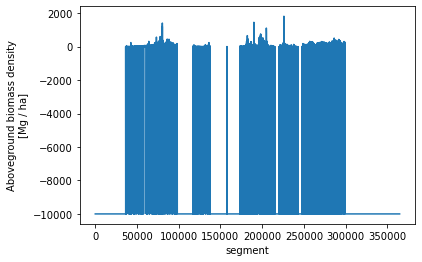

In [14]:
#plot agbd from the gedi dataset
gedi_ds.agbd.plot() ;

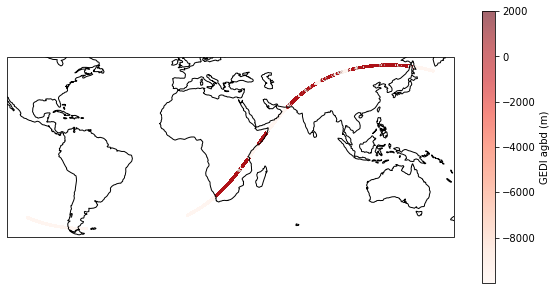

In [15]:
#plot location of data and values

map_proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=map_proj)
ax.coastlines()



# Plot IS2 surface height 
gedi_img = ax.scatter(gedi_ds.lon_lowestmode, gedi_ds.lat_lowestmode,
                     c=gedi_ds.agbd, 
                     vmax=2000,  # Set max height to plot
                     cmap='Reds', alpha=0.6, s=2
                     )

# Add colorbars

fig.colorbar(gedi_img, label='GEDI agbd (m)')
